# Preprocessing BRATS_METS dataset
Alright everyone, let's do this one last time.

Link to challenge: https://www.synapse.org/Synapse:syn53708249/wiki/626323

Infos about the dataset:
- the dataset contains "only" brain metastases of treatment-naive brain metastases mpMRI scans obtained from various institutions
- t1, t1c, t2, flair and segmentation is included
- no information about the patients or their primary cancers is available

The dataset structure looks like this:
```
BraTS2024-MET-Challenge-all
│
│__BraTS-MET-00001-000
    │
    │__BraTS-MET-00001-000-seg.nii.gz
    │__BraTS-MET-00001-000-t1c.nii.gz
    │__BraTS-MET-00001-000-t1n.nii.gz
    │__BraTS-MET-00001-000-t2f.nii.gz
    │__BraTS-MET-00001-000-t2n.nii.gz
│
│__...
```

Note that sometimes there's a second folder for a certain patient, like ```BraTS-MET-00591-000```and ```BraTS-MET-00591-001```. If I understand correctly, that just means that during the duration of the disease multiple mri scans were done for this certain patient.

In [1]:
# TO-DO:
# [ ] Percentile normalize images
# [ ] Create png images of each visible brain metastases slice in each scan
# [ ] Combine the four sequences and the segmentation mask into a single tfrecord file
# [ ] Profit?

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from pathlib import Path
import random
import nibabel as nib
#from skimage.measure import label
import skimage.measure as measure

Paths

In [2]:
path_to_brats_mets_dataset_folder = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/BRATS_2024/BraTS-MET/BraTS2024-MET-Challenge-all")
path_to_brats_mets_png_slices = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/BRATS_2024/BraTS-MET/BraTS2024-MET-pngs")
path_to_brats_mets_tfrecords = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/BRATS_2024/BraTS-MET/BraTS2024-MET-tfrecords")

In [3]:
IMG_SIZE = 240

Custom Patient Class to store paths to different files

In [4]:
# create custom class for each patient to store all relevant information

class Patient:
    def __init__(self, id):
        self.id = id

        self.t1 = None # Path to T1 image
        self.t1c = None # Path to T1c image
        self.t2 = None # Path to T2 image
        self.flair = None # Path to FLAIR image

        self.tumor_segmentation = None # Path to tumor segmentation mask

In [5]:
brats_patients = []
patients_with_missing_data = []

patient_ids = [
    x for x in os.listdir(path_to_brats_mets_dataset_folder)
    if os.path.isdir(os.path.join(path_to_brats_mets_dataset_folder, x))
]

# loop through autmatic tumor segmentation ids
# get four regular sequences
# get tumor segmentation mask
for id in tqdm(patient_ids):
    patient = Patient(id = id)
    path_to_t1 = path_to_brats_mets_dataset_folder / f'{id}' / f'{id}-t1n.nii.gz'
    path_to_t1c = path_to_brats_mets_dataset_folder / f'{id}' / f'{id}-t1c.nii.gz'
    path_to_t2 = path_to_brats_mets_dataset_folder / f'{id}' / f'{id}-t2w.nii.gz'
    path_to_flair = path_to_brats_mets_dataset_folder / f'{id}' / f'{id}-t2f.nii.gz'
    path_to_automatic_segmentation = path_to_brats_mets_dataset_folder / f'{id}' / f'{id}-seg.nii.gz'

    if path_to_t1.is_file():
        patient.t1 = path_to_t1
    else:
        patients_with_missing_data.append(id)
        print(f'No T1 image for patient {id}')
    
    if path_to_t1c.is_file():
        patient.t1c = path_to_t1c
    else:
        patients_with_missing_data.append(id)
        print(f'No T1c image for patient {id}')

    if path_to_t2.is_file():
        patient.t2 = path_to_t2
    else:
        patients_with_missing_data.append(id)
        print(f'No T2 image for patient {id}')
    
    if path_to_flair.is_file():
        patient.flair = path_to_flair
    else:
        patients_with_missing_data.append(id)
        print(f'No FLAIR image for patient {id}')
    
    if path_to_automatic_segmentation.is_file():
        patient.tumor_segmentation = path_to_automatic_segmentation
    else:
        patients_with_missing_data.append(id)
        print(f'No tumor segmentation mask for patient {id}')

    brats_patients.append(patient)

100%|██████████| 652/652 [00:00<00:00, 4806.52it/s]


In [6]:
print(f'Number of patients with missing data: {len(patients_with_missing_data)}')
print(f'Number of patients with complete data: {len(brats_patients)}')

Number of patients with missing data: 0
Number of patients with complete data: 652


In [7]:
def visualize_random_patients(all_patients):

    # Funktion zum Laden und Anzeigen eines NIfTI-Bildes
    def load_nifti_image(path):
        return nib.load(str(path)).get_fdata()

    # 9 zufällige Patienten auswählen
    random_patients = random.sample(all_patients, 9)

    # 3x3 Grafik erstellen
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    for i, patient in enumerate(random_patients):
        ax = axes[i // 3, i % 3]
        
        # Zufällige MRT Sequenz auswählen
        sequences = [patient.t1, patient.t1c, patient.t2, patient.flair]
        sequence_path = random.choice([seq for seq in sequences if seq is not None])
        
        # MRT Bild laden
        image = load_nifti_image(sequence_path)
        
        # Segmentierung laden
        segmentation = load_nifti_image(patient.tumor_segmentation)
        
        # Größte sichtbare Tumorschicht finden
        slice_index = np.argmax(np.sum(segmentation, axis=(0, 1)))
        
        # MRT Bild anzeigen
        ax.imshow(image[:, :, slice_index], cmap = 'gray')
        
        # Segmentierung farblich darüber legen
        ax.imshow(segmentation[:, :, slice_index], cmap='Reds', alpha=0.5)
        
        ax.axis('off')

        # Title
        max_value = np.max(image)
        mean_value = np.mean(image)
        min_value = np.min(image)

        title = (
            f'Patient {patient.id}\n'
            f'Sequence: {sequence_path.name}\n'
            f'Max: {max_value:.2f}, Mean: {mean_value:.2f}, Min: {min_value:.2f}\n'
            f'Shape: {image.shape}'
        )

        ax.set_title(f'{title}')

    plt.tight_layout()
    plt.show()

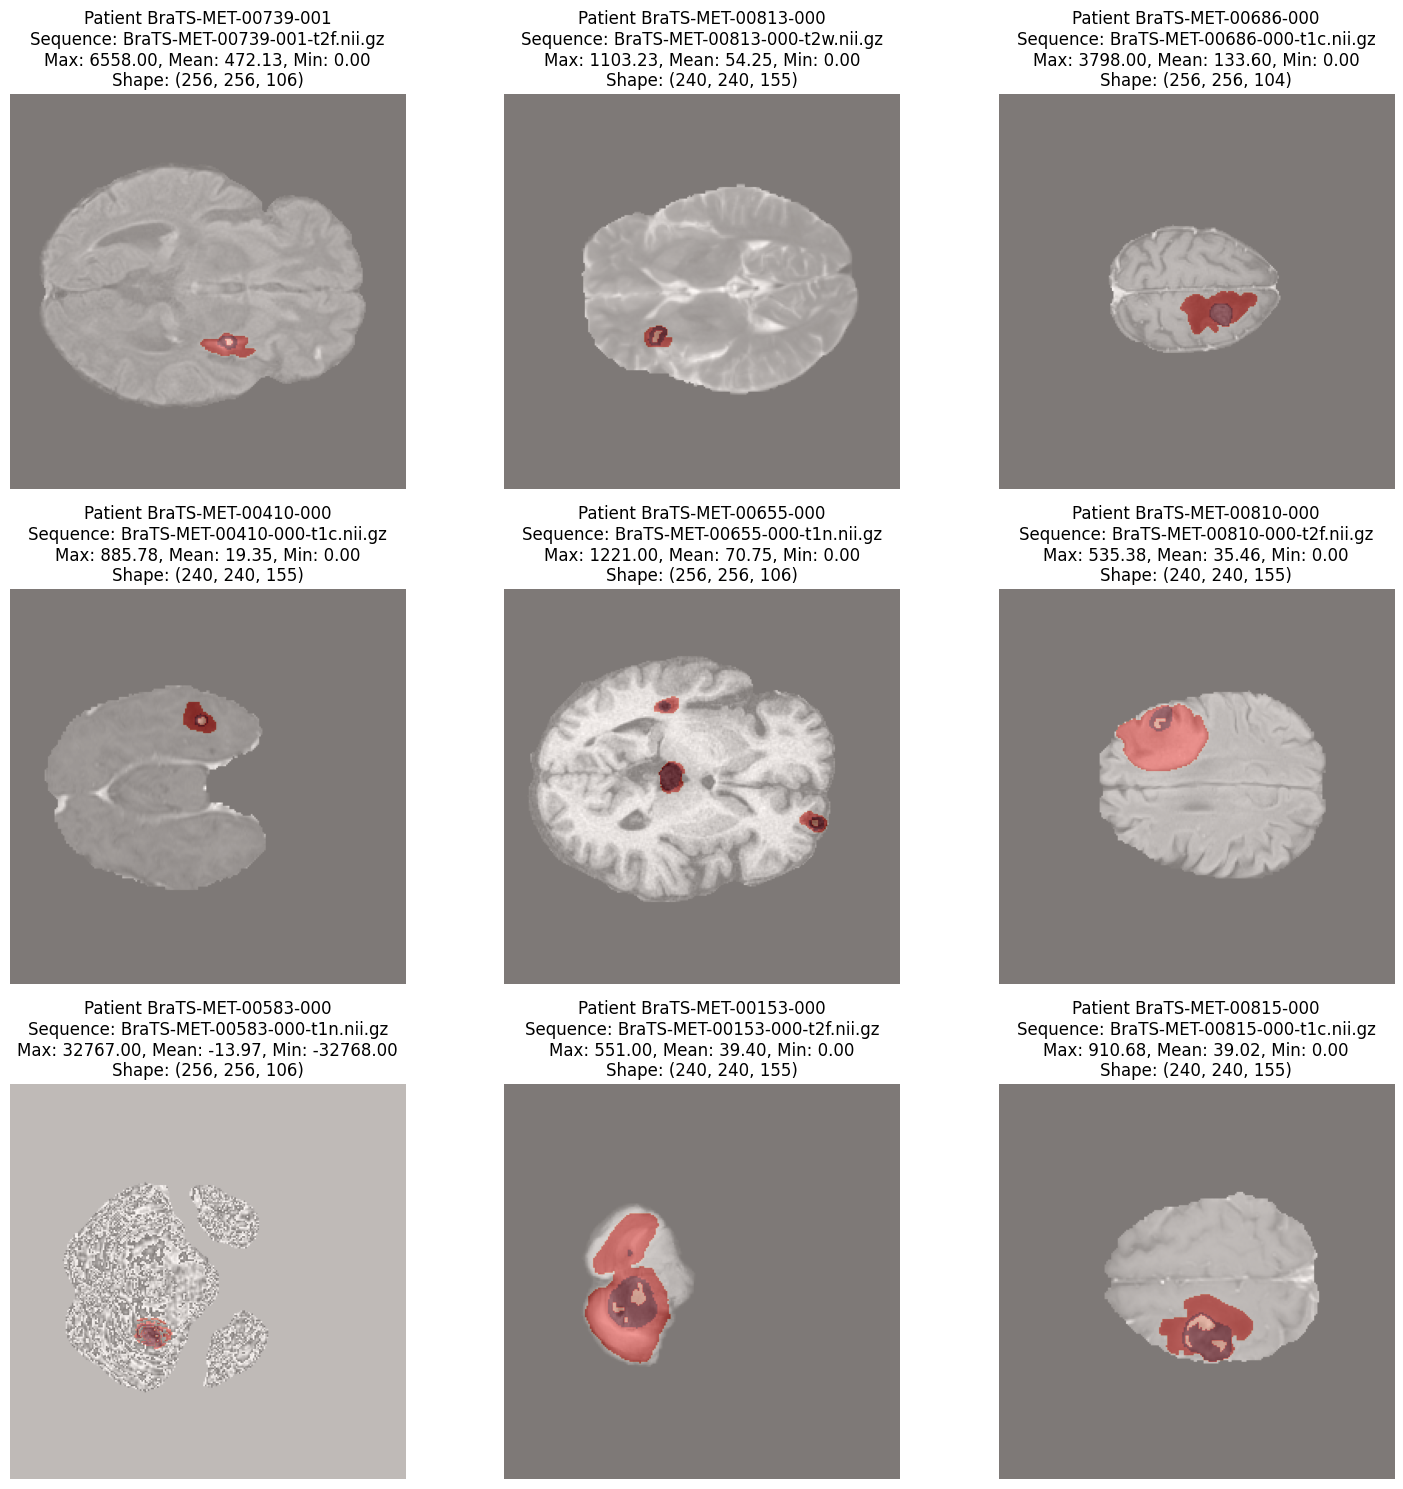

In [17]:
visualize_random_patients(brats_patients)

most images still need percentile normalization, reorientation and rotation

## Reorient, percentile normalize and rotate file

In [8]:
def rotate_and_normalize(image):
    # Rotate the image 90 degrees
    rotated_image = np.rot90(image, k=1)
    
    # Percentile normalization
    lower_percentile = np.percentile(rotated_image, 1)
    upper_percentile = np.percentile(rotated_image, 99)
    normalized_image = np.clip(rotated_image, lower_percentile, upper_percentile)
    normalized_image = (normalized_image - lower_percentile) / (upper_percentile - lower_percentile)
    
    return normalized_image

def load_nifti_image(path):

    img = nib.load(path)
    
    # rotate image to canonical orientation
    # If it's a Nifti1Pair, convert it to a Nifti1Image
    if isinstance(img, nib.Nifti1Pair):
        data = img.get_fdata()
        affine = img.affine  # nibabel usually infers or loads the affine
        # Create a brand-new Nifti1Header from the old header
        new_header = nib.Nifti1Header.from_header(img.header)
        # Make a Nifti1Image
        img = nib.Nifti1Image(data, affine, header=new_header)

    # Now safely reorient to canonical (RAS) orientation
    img_canonical = nib.as_closest_canonical(img)

    return img_canonical.get_fdata()

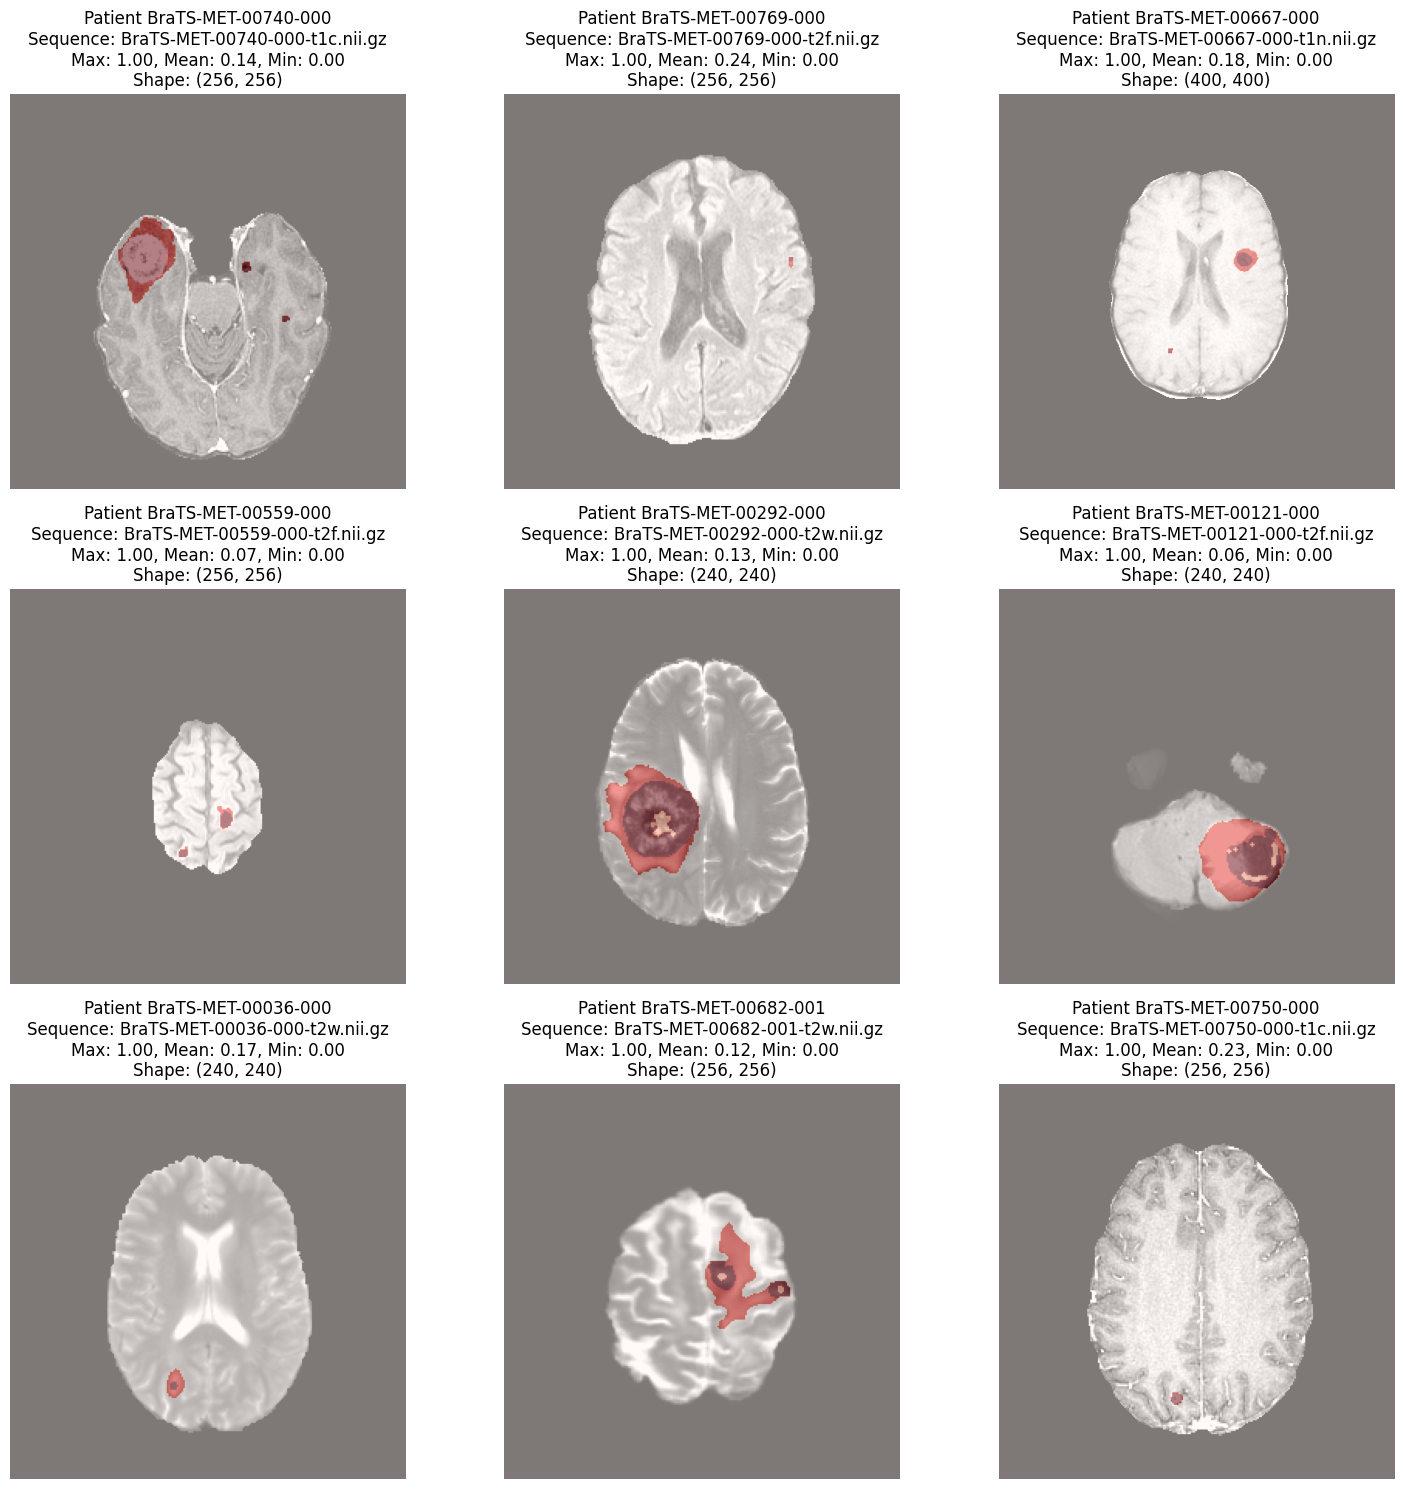

In [9]:
def visualize_random_patients_rotated_normalized(all_patients):

    random_patients = random.sample(all_patients, 9)
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    for i, patient in enumerate(random_patients):
        ax = axes[i // 3, i % 3]
        sequences = [patient.t1, patient.t1c, patient.t2, patient.flair]
        sequence_path = random.choice([seq for seq in sequences if seq is not None])
        image = load_nifti_image(sequence_path)
        # image = reorient_image(image).get_fdata()
        segmentation = load_nifti_image(patient.tumor_segmentation)
        # segmentation = reorient_image(segmentation).get_fdata()
        slice_index = np.argmax(np.sum(segmentation, axis=(0, 1)))
        
        # Rotate and normalize the image and segmentation
        image_rotated_normalized = rotate_and_normalize(image[:, :, slice_index])
        segmentation_rotated = np.rot90(segmentation[:, :, slice_index], k=1)
        
        ax.imshow(image_rotated_normalized, cmap='gray', alpha = 1)
        ax.imshow(segmentation_rotated, cmap='Reds', alpha=0.5)
        ax.axis('off')

        max_value = np.max(image_rotated_normalized)
        mean_value = np.mean(image_rotated_normalized)
        min_value = np.min(image_rotated_normalized)

        title = (
            f'Patient {patient.id}\n'
            f'Sequence: {sequence_path.name}\n'
            f'Max: {max_value:.2f}, Mean: {mean_value:.2f}, Min: {min_value:.2f}\n'
            f'Shape: {image_rotated_normalized.shape}'
        )

        ax.set_title(f'{title}')

    plt.tight_layout()
    plt.show()

visualize_random_patients_rotated_normalized(brats_patients)

## Save the slice with the largest area for each metastasis

In [10]:
def show_segmentation_classes(patient):
    def load_nifti_image(path):
        return nib.load(str(path)).get_fdata()

    segmentation = load_nifti_image(patient.tumor_segmentation)
    unique_classes = np.unique(segmentation)
    
    print(f"Unique segmentation classes for patient {patient.id}: {unique_classes}")

# Example usage for a random patient
random_patient = random.choice(brats_patients)
show_segmentation_classes(random_patient)

Unique segmentation classes for patient BraTS-MET-00665-000: [0. 2. 3.]


Meaning of each number:

Nonenhancing tumor core (NETC; Label 1): All portions of tumor core without contrast enhancement that are enclosed by enhancing tumor (ET). It represents the bulk of the tumor, which is what is typically considered for surgical excision.

Surrounding non-enhancing FLAIR hyperintensity (SNFH; Label 2): peritumoral edematous and infiltrated tissue, defined by the abnormal hyperintense signal envelope on the T2 FLAIR volumes, which includes the infiltrative non enhancing tumor, as well as vasogenic edema in the peritumoral region. Non tumor related FLAIR signal abnormality such as prior infarcts or microvascular ischemic white matter changes are NOT included.

Enhancing Tumor (ET; Label 3): All tumor portions with noticeable contrast enhancement on postcontrast T1-weighted images. Adjacent blood vessels, bleeding or intrinsic T1 hyperintensity are NOT included in this label.

I will focus on the Enhancing Tumor (ET; Label 3)

In [60]:
def save_metastases_pngs_for_patient(patient, output_folder, area_threshold=10):
    """
    For the given patient:
      1) Load & rotate & normalize all available sequences (T1, T1c, T2, FLAIR).
      2) Load the segmentation, rotate it.
      3) Label each metastasis individually (using skimage.measure.label).
      4) For each labeled metastasis:
         a) Check the total 3D volume vs. volume_threshold (in voxel count).
         b) If below threshold, skip it.
         c) Otherwise find the slice index that maximizes area.
         d) Save one PNG per sequence plus one PNG for ALL metastases in that slice.
    """

    # Ensure output path exists
    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)

    # -- Helper function for loading in nibabel and reorienting/normalizing --
    def load_nifti_image(path):
        img = nib.load(str(path))
        img_canonical = nib.as_closest_canonical(img)
        return img_canonical.get_fdata()

    def rotate_and_normalize_3d(data_3d):
        """
        Rotate the entire 3D volume 90 degrees counter clockwise around the (0,1) axes
        and apply a percentile normalization in 3D between 1st and 99th percentile.
        """
        rotated_3d = np.rot90(data_3d, k=1, axes=(0,1))
        lower_p = np.percentile(rotated_3d, 1)
        upper_p = np.percentile(rotated_3d, 99)
        clipped_3d = np.clip(rotated_3d, lower_p, upper_p)
        normalized_3d = (clipped_3d - lower_p) / (upper_p - lower_p)
        return normalized_3d

    # --- 1) Load T1, T1c, T2, FLAIR sequences (if they exist) ---
    sequences = [("t1",   patient.t1),
                 ("t1c",  patient.t1c),
                 ("t2",   patient.t2),
                 ("flair",patient.flair)]
    
    loaded_sequences = []
    sequence_names = []

    for seq_name, seq_path in sequences:
        if seq_path is not None and seq_path.is_file():
            data_3d = load_nifti_image(seq_path)
            data_3d_rot_norm = rotate_and_normalize_3d(data_3d)
            loaded_sequences.append(data_3d_rot_norm)
            sequence_names.append(seq_name)
        else:
            loaded_sequences.append(None)
            sequence_names.append(seq_name)

    # --- 2) Load & rotate the segmentation ---
    seg_data = load_nifti_image(patient.tumor_segmentation)
    seg_data_rotated = np.rot90(seg_data, k=1, axes=(0,1))

    # In your BRATS METS segmentation, the metastatic tumor is typically:
    #   label 1: non-enhancing tumor
    #   label 3: enhancing tumor
    tumor_mask = (seg_data_rotated == 1) | (seg_data_rotated == 3)

    # --- 3) Label each metastasis individually ---
    labeled_mask = measure.label(tumor_mask, connectivity=1)  
    num_metastases = labeled_mask.max()
    print(f"{patient.id}: Number of metastases found (before size cutoff): {num_metastases}")

    z_dim = labeled_mask.shape[2]

    # --- 4) For each metastasis, filter by size and then find largest slice ---
    count_kept = 0
    for primary_metastasis_idx in range(1, num_metastases + 1):
        # 4a) Get total volume (voxel count) of primary metastasis
        primary_metastasis_volume = np.sum(labeled_mask == primary_metastasis_idx)

        # Find the slice with the largest cross-sectional area for the primary metastasis
        slice_areas = [
            np.sum(labeled_mask[:, :, z_idx] == primary_metastasis_idx)
            for z_idx in range(z_dim)
        ]
        largest_slice_idx = np.argmax(slice_areas)

        largest_area = np.max(slice_areas)
        print(f"Metastasis {primary_metastasis_idx}: Largest area = {largest_area}")
        if largest_area < area_threshold:
            continue

        count_kept += 1

        # Find all metastases present in this slice
        slice_metastases = np.unique(labeled_mask[:, :, largest_slice_idx])
        slice_metastases = [m for m in slice_metastases if m > 0]

        # 4d) Save the slices for each sequence and mask in a new folder
        met_folder = output_folder / f"{patient.id}"
        met_folder.mkdir(parents=True, exist_ok=True)

        for seq_data, seq_name in zip(loaded_sequences, sequence_names):
            if seq_data is None:
                continue
            slice_2d = seq_data[:, :, largest_slice_idx]
            slice_2d_8bit = (slice_2d * 255).astype(np.uint8)
            out_path = met_folder / f"{patient.id}_{primary_metastasis_idx}_{largest_slice_idx}_{largest_area}_{seq_name}.png"
            cv2.imwrite(str(out_path), slice_2d_8bit)

        # Save the mask for ALL metastases on this slice
        metastasis_mask_slice = np.zeros_like(labeled_mask[:, :, largest_slice_idx], dtype=np.uint8)
        for met_idx in slice_metastases:
            metastasis_mask_slice |= (labeled_mask[:, :, largest_slice_idx] == met_idx)
        
        metastasis_mask_8bit = (metastasis_mask_slice * 255)
        mask_out_path = met_folder / f"{patient.id}_{primary_metastasis_idx}_{largest_slice_idx}_{largest_area}_mask.png"
        cv2.imwrite(str(mask_out_path), metastasis_mask_8bit)

    print(f"{patient.id}: Kept {count_kept} metastases after size cutoff (volume_threshold={area_threshold}).")

In [16]:
save_metastases_pngs_for_patient(random_patient, path_to_brats_mets_png_slices)

BraTS-MET-00749-000: Number of metastases found (before size cutoff): 2
Metastasis 1: Largest area = 948
Metastasis 2: Largest area = 25
BraTS-MET-00749-000: Kept 2 metastases after size cutoff (volume_threshold=10).


In [63]:
# loop over all patients and save the pngs

# seems like the T2 sequence for patient BraTS-MET-00232-000 is corrupted
patients_to_skip = ["BraTS-MET-00232-000"]

counter = 1

for patient in brats_patients:
    print(f"Processing patient {counter} of {len(brats_patients)}: {patient.id}")
    counter += 1

    if patient.id in patients_to_skip:
        print(f"Skipping patient {patient.id}")
        continue

    save_metastases_pngs_for_patient(patient, path_to_brats_mets_png_slices)
    print()

Processing patient 1 of 652: BraTS-MET-00561-002
BraTS-MET-00561-002: Number of metastases found (before size cutoff): 5
Metastasis 1: Largest area = 20
Metastasis 2: Largest area = 16
Metastasis 3: Largest area = 546
Metastasis 4: Largest area = 56
Metastasis 5: Largest area = 61
BraTS-MET-00561-002: Kept 5 metastases after size cutoff (volume_threshold=10).

Processing patient 2 of 652: BraTS-MET-00086-000
BraTS-MET-00086-000: Number of metastases found (before size cutoff): 3
Metastasis 1: Largest area = 29
Metastasis 2: Largest area = 33
Metastasis 3: Largest area = 43
BraTS-MET-00086-000: Kept 3 metastases after size cutoff (volume_threshold=10).

Processing patient 3 of 652: BraTS-MET-00640-001
BraTS-MET-00640-001: Number of metastases found (before size cutoff): 5
Metastasis 1: Largest area = 4
Metastasis 2: Largest area = 31
Metastasis 3: Largest area = 61
Metastasis 4: Largest area = 15
Metastasis 5: Largest area = 29
BraTS-MET-00640-001: Kept 4 metastases after size cutoff (v

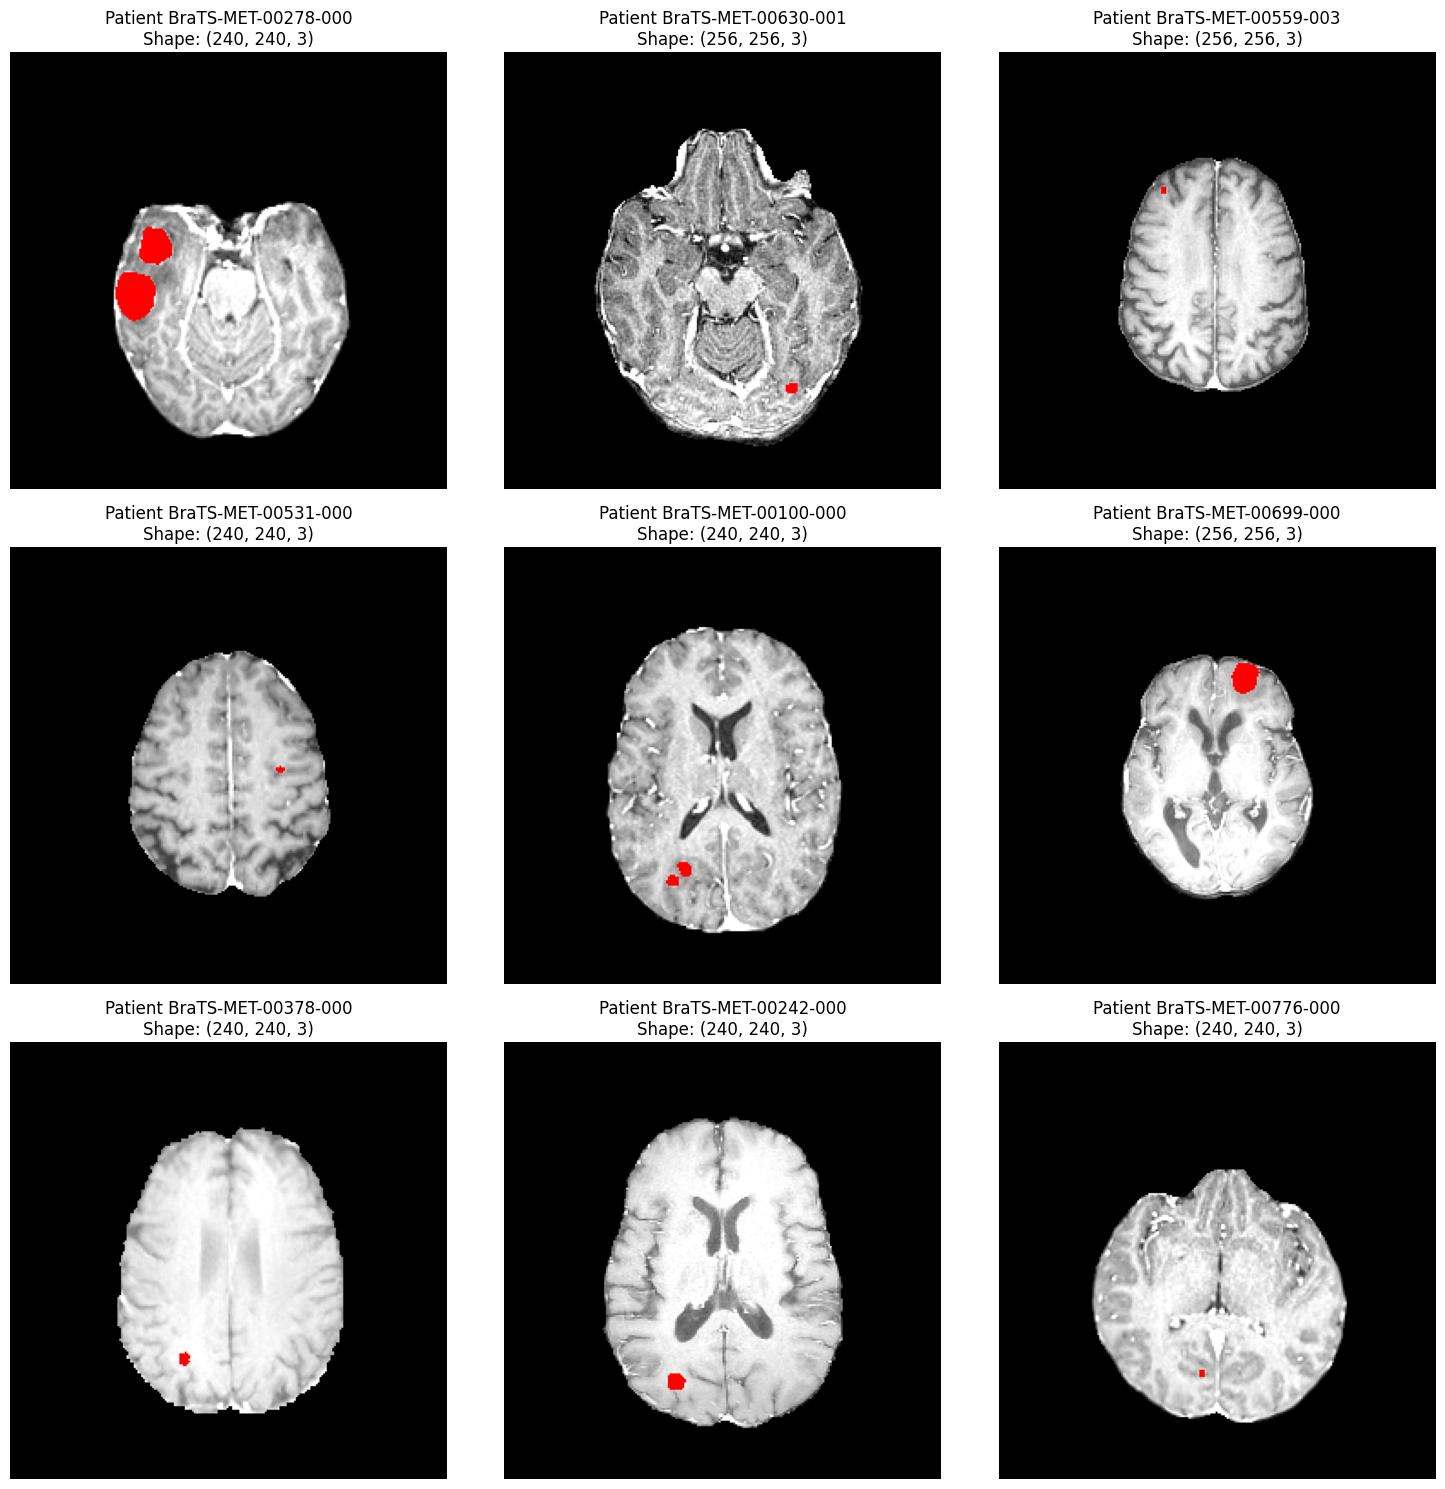

In [64]:
def display_random_metastases(patients, png_slices_folder):
    random_patients = random.sample(patients, 9)
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    for i, patient in enumerate(random_patients):
        ax = axes[i // 3, i % 3]
        patient_folder = png_slices_folder / patient.id

        if not patient_folder.exists():
            ax.axis('off')
            ax.set_title(f'No data for patient {patient.id}')
            continue

        # metastasis_folders = [f for f in patient_folder.iterdir() if f.is_dir()]
        # if not metastasis_folders:
        #     ax.axis('off')
        #     ax.set_title(f'No metastases for patient {patient.id}')
        #     continue

        # random_metastasis_folder = random.choice(metastasis_folders)
        sequence_png_files = list(patient_folder.glob("*_t1c.png"))  # Adjust the pattern to match sequence PNGs

        if not sequence_png_files:
            ax.axis('off')
            ax.set_title(f'No sequence PNGs for patient {patient.id}')
            continue

        random_png = random.choice(sequence_png_files)
        image = cv2.imread(str(random_png), cv2.IMREAD_GRAYSCALE)

        # Overlay mask in red
        mask_file = random_png.with_name(random_png.stem.replace('_t1c', '_mask') + random_png.suffix)
        if mask_file.exists():
            mask = cv2.imread(str(mask_file), cv2.IMREAD_GRAYSCALE)
            image = cv2.merge([image, image, image])  # Convert to 3-channel image
            image[mask > 0] = [255, 0, 0]  # Overlay mask in red

        ax.imshow(image)
        ax.axis('off')
        ax.set_title(
            f'Patient {patient.id}\n'
            f'Shape: {image.shape}'
        )

    plt.tight_layout()
    plt.show()

display_random_metastases(brats_patients, path_to_brats_mets_png_slices)

## Create TFRecord Files for patients
during the creation the image also get resized to 240x240 to further unify the dataset

In [7]:
def serialize_example(image, label):
    """
    image: A NumPy array containing the image (could be shape (H, W, 5) or (H, W, 3, 5))
    label: Integer label (you can adapt this to your actual label)
    """

    # If 'image' is already a NumPy array, just flatten it:
    image_flattened = image.ravel()

    # Create a tf.train.Example
    tumor_example = tf.train.Example(
        features=tf.train.Features(
            feature={
                'image': tf.train.Feature(float_list=tf.train.FloatList(value=image_flattened)),
                'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
            }
        )
    )
    return tumor_example.SerializeToString()

In [8]:
def create_metastasis_tfrecords(
    png_root_folder, 
    tfrecord_base_output_folder, 
    labels_dict=None
):
    """
    Generate TFRecord files for each metastasis, separating RGB and grayscale into different folders.
    """
    # Create separate folders for RGB and grayscale TFRecords
    tfrecord_rgb_folder = Path(tfrecord_base_output_folder) / 'BRATS_rgb'
    tfrecord_gray_folder = Path(tfrecord_base_output_folder) / 'BRATS_gray'

    tfrecord_rgb_folder.mkdir(parents=True, exist_ok=True)
    tfrecord_gray_folder.mkdir(parents=True, exist_ok=True)

    patient_folders = list(Path(png_root_folder).iterdir())
    amount_patients = len(patient_folders)

    options = tf.io.TFRecordOptions(compression_type="GZIP")


    # Iterate through patient folders
    for patient_folder in tqdm(patient_folders):
        if not patient_folder.is_dir():
            continue
        
        patient_id = patient_folder.name

        # create folder for patient
        (tfrecord_rgb_folder / patient_id).mkdir(parents=True, exist_ok=True)
        (tfrecord_gray_folder / patient_id).mkdir(parents=True, exist_ok=True)

        # Get label from dict or default to 4
        label = labels_dict.get(patient_id, 0) if labels_dict else 4

        # Find all metastasis PNG files for this patient
        metastasis_files = sorted(patient_folder.glob(f"{patient_id}_*"))
        
        # Group files by metastasis
        metastasis_groups = {}
        for file in metastasis_files:
            parts = file.stem.split('_')
            if len(parts) < 5:
                continue
            met_key = f"{parts[1]}_{parts[3]}"  # metastasis index and metastases area
            if met_key not in metastasis_groups:
                metastasis_groups[met_key] = []
            metastasis_groups[met_key].append(file)

        # Process each metastasis
        for met_key, met_files in metastasis_groups.items():
            # Separate files by type
            met_files_dict = {f.stem.split('_')[-1]: f for f in met_files}
            
            # Ensure all required images exist
            required_images = ['t1', 't1c', 't2', 'flair', 'mask']
            if not all(img in met_files_dict for img in required_images):
                print(f"Skipping incomplete metastasis: {met_key}")
                continue

            # Read images
            images = []
            for img_type in required_images:
                img_path = met_files_dict[img_type]
                # Read as grayscale
                img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to 240x240
                img = img.astype(np.float32)
                images.append(img)

            # Prepare grayscale TFRecord
            grayscale_image = np.stack(images, axis=-1)
            grayscale_tfrecord_path = tfrecord_gray_folder / patient_id / f"{patient_id}_{met_key}_label_4.tfrecord"
            
            with tf.io.TFRecordWriter(str(grayscale_tfrecord_path), options) as writer:
                example = serialize_example(grayscale_image, label)
                writer.write(example)

            # Prepare RGB TFRecord
            rgb_images = [np.stack([img, img, img], axis=-1) for img in images]
            rgb_image = np.stack(rgb_images, axis=-1)
            
            rgb_tfrecord_path = tfrecord_rgb_folder / patient_id / f"{patient_id}_{met_key}_label_4.tfrecord"
            
            with tf.io.TFRecordWriter(str(rgb_tfrecord_path), options) as writer:
                example = serialize_example(rgb_image, label)
                writer.write(example)

# Example usage
# create_metastasis_tfrecords(
#     png_root_folder='/path/to/patient/metastasis/pngs', 
#     tfrecord_base_output_folder='/path/to/output/tfrecords',
#     labels_dict={'patient1': 0, 'patient2': 1}
# )

In [9]:
create_metastasis_tfrecords(
    png_root_folder = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/BRATS_2024/BraTS-MET/BraTS2024-MET-pngs",
    tfrecord_base_output_folder = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/BRATS_2024/BraTS-MET/BraTS2024-MET-tfrecords"
)

100%|██████████| 646/646 [12:25<00:00,  1.15s/it]


## Read TFRecord Files

<_TakeDataset element_spec=(TensorSpec(shape=(240, 240, 5), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Label: 4
(240, 240, 5)


2025-01-24 16:01:56.358766: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


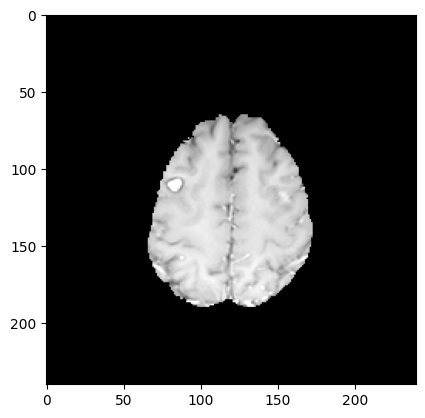

In [70]:
path_to_testing_tfr = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/BRATS_2024/BraTS-MET/BraTS2024-MET-tfrecords/BRATS_gray/BraTS-MET-00005-000/BraTS-MET-00005-000_3_55.tfrecord"
rgb = False

num_images = 5 # 4 sequences + 1 mask

image_shape = []

if rgb: # rgb images need three channels
    image_shape = [240, 240, 3, num_images]
else: # gray scale images don't
    image_shape = [240, 240, num_images]

feature_description = {
    "image": tf.io.FixedLenFeature(image_shape, tf.float32),
    "label": tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def parse(serialize_patient):
    example = tf.io.parse_single_example(serialize_patient, feature_description)

    image = example["image"]
    image = tf.reshape(image, image_shape) #[149, 185, 155, 4] = old size
    
    return image, example["label"]

dataset = tf.data.TFRecordDataset([path_to_testing_tfr], compression_type="GZIP")
parsed_dataset = dataset.map(parse)

test_image = parsed_dataset.take(1)
print(test_image)
for image, label in test_image:
    print(f"Label: {label.numpy()}")
    numpy_image = image.numpy()
    print(numpy_image.shape)
    if rgb:
        plt.imshow(numpy_image[:,:,2,1], cmap='gray')
    else:
        plt.imshow(numpy_image[:,:,1], cmap='gray')

## Dataset Summary

In [5]:
# get amount of patients and total metatases count
path_to_rgb_tfrecords = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/BRATS_2024/BraTS-MET/BraTS2024-MET-tfrecords/BRATS_rgb"

patient_folders = list(Path(path_to_rgb_tfrecords).iterdir())
patient_folders = [f for f in patient_folders if f.is_dir()]
amount_patients = len(patient_folders)

amount_metastases = 0
for patient_folder in patient_folders:
    patient_metatatases = list(Path(patient_folder).iterdir())
    amount_metastases += len(patient_metatatases)

print("-- Results --")
print(f"Amount of patients: {amount_patients}")
print(f"Amount of metastases: {amount_metastases}")

-- Results --
Amount of patients: 645
Amount of metastases: 4063
